In [178]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats as st
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import theano

from scipy.special import logsumexp

%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-darkgrid'])

# Code Examples

#### Code 6.1

In [3]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,brain,mass,species
0,438,37.0,afarensis
1,452,35.5,africanus
2,612,34.5,habilis
3,521,41.5,boisei
4,752,55.5,rudolfensis
5,871,61.0,ergaster
6,1350,53.5,sapiens


#### Code 6.2

In [4]:
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#### Code 6.3

In [5]:
1 - m_6_1.resid.var()/d.brain.var()

# m_6_1.summary() check the value for R-squared

0.490158047949084

#### Code 6.4

In [6]:
m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

#### Code 6.5

In [7]:
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

#### Code 6.6

In [8]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

#### Code 6.7

In [9]:
d_new = d.drop(d.index[-1])

#### Code 6.8

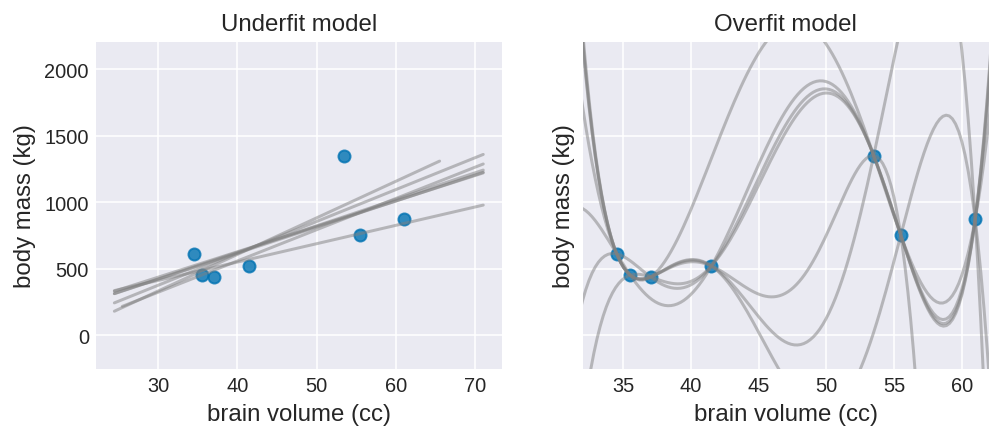

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()

#### Code 6.9

In [11]:
p = (0.3, 0.7)
-sum(p * np.log(p))

0.6108643020548935

#### Code 6.10

In [12]:
# fit model
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#compute de deviance by cheating
-2 * m_6_1.llf

94.92498968588757

#### Code 6.11

In [17]:
# standarize the mass before fitting
d['mass_s'] = d['mass'] - np.mean(d['mass'] / np.std(d['mass']))

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain']) * 10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    m_6_8 = pm.sample(2000, tune=5000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_interval__, b, a]
100%|██████████| 7000/7000 [00:09<00:00, 763.49it/s]


In [18]:
theta = pm.summary(m_6_8)['mean'][:3]

In [19]:
#compute deviance
dev = - 2 * sum(stats.norm.logpdf(d['brain'], loc = theta[0] + theta[1] * d['mass_s']  , scale = theta[2]))
dev 

100.53210132036774

#### Code 6.12

[This](https://github.com/rmcelreath/rethinking/blob/a309712d904d1db7af1e08a76c521ab994006fd5/R/sim_train_test.R) is the original function.

In [31]:
# This function only works with number of parameters >= 2 

def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]
    
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
    
    mm_train = np.ones((N,1))
    
    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)
    
    #Using pymc3
    
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(n_dim), 
                            shape=(1, n_dim), testval=np.random.randn(1, n_dim)*.01)
        mu = pm.Deterministic('mu', 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample()
        
    vec = pm.summary(trace_m_sim)['mean'][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)
    
    dev_train = - 2 * sum(stats.norm.logpdf(x_train, loc = np.matmul(x_train, vec), scale = 1))    
    
    mm_test = np.ones((N,1))
    
    mm_test = np.concatenate([mm_test, x_test[:, 1:k +1]], axis=1)
    
    dev_test = - 2 * sum(stats.norm.logpdf(x_test[:,0], loc = np.matmul(mm_test, vec), scale = 1))    
    
    return np.mean(dev_train), np.mean(dev_test)

In [32]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j -2, :] = np.mean(train), np.std(train, ddof=1), np.mean(test), np.std(test, ddof=1)

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 362.70it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 338.62it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:03<00:00, 297.51it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 339.87it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 359.20it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_di

3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 350.55it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 345.80it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:03<00:00, 327.06it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 366.99it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 349.70it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_di

4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:03<00:00, 273.73it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:04<00:00, 243.95it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:03<00:00, 322.43it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 354.99it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:03<00:00, 320.30it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_di

5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 344.47it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 371.21it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 395.40it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 348.25it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 347.47it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_di

6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 347.74it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:03<00:00, 330.10it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:03<00:00, 302.75it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 350.95it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vec_V]
100%|██████████| 1000/1000 [00:02<00:00, 339.07it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_di

#### Code 6.14

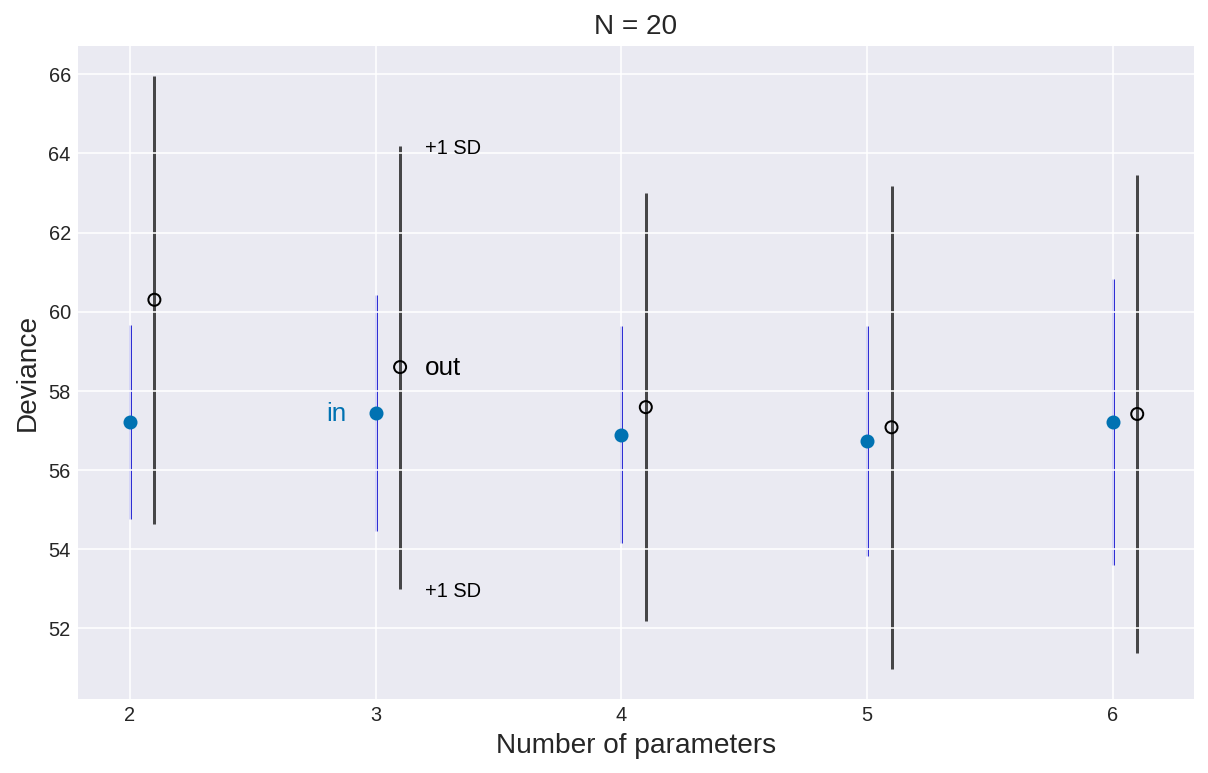

In [35]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color='C0')
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(num_param[j], r[j,0] - r[j, 1], r[j,0] + r[j,1], color='mediumblue', 
               zorder=-1, alpha=0.80)

plt.scatter(num_param + 0.1, r[:, 2], facecolors='none', edgecolors='k')

for j in range(param - 1):
    plt.vlines(num_param[j] + 0.1, r[j,2] - r[j, 3], r[j,2] + r[j,3], color='k', 
               zorder=-2, alpha=0.70)    

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, 'in', color='C0', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, 'out', color='k', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.xlabel('Number of parameters', fontsize=14)
plt.ylabel('Deviance', fontsize=14)
plt.title('N = {}'.format(n), fontsize=14)
plt.show()

#### Code 6.15

In [9]:
data = pd.read_csv('Data/cars.csv', sep=',')

In [10]:
with pm.Model() as m_6_15 :
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    m_6_15 = pm.sample(5000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_interval__, b, a]
100%|██████████| 15000/15000 [00:36<00:00, 412.92it/s]
The acceptance probability does not match the target. It is 0.8918815238809351, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 6.16

In [29]:
n_samples = 1000
n_cases = data.shape[0]
ll = np.zeros((n_cases, n_samples))

In [30]:
for s in range(0, n_samples):
    mu = m_6_15['a'][s] + m_6_15['b'][s] * data['speed']
    p_ = stats.norm.logpdf(data['dist'], loc=mu, scale=m_6_15['sigma'][s])
    ll[:,s] = p_

#### Code 6.17

In [34]:
n_cases = data.shape[0]
lppd = np.zeros((n_cases))
for a in range(1, n_cases):
    lppd[a,] = logsumexp(ll[a,]) - np.log(n_samples)

#### Code 6.18

In [35]:
pWAIC = np.zeros((n_cases))
for i in range(1, n_cases):
    pWAIC[i,] = np.var(ll[i,])

#### Code 6.19

In [36]:
- 2 * (sum(lppd) - sum(pWAIC))

411.6004356317752

#### Code 6.20

In [37]:
waic_vec = - 2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

14.997826680892612

#### Code 6.21

In [12]:
d = pd.read_csv('Data/milk.csv', sep=';')
d['neocortex'] = d['neocortex.perc'] / 100
d.dropna(inplace=True)
d.shape

(17, 9)

#### Code 6.22

In [13]:
a_start = d['kcal.per.g'].mean()
sigma_start = d['kcal.per.g'].std()

In [14]:
mass_shared = theano.shared(np.log(d['mass'].values))
neocortex_shared = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    mu = alpha + 0 * neocortex_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_11 = pm.sample(1000, tune=1000)    

with pm.Model() as m6_12:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    mu = alpha + beta * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_12 = pm.sample(5000, tune=15000)
    
with pm.Model() as m6_13:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta * mass_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_13 = pm.sample(1000, tune=1000)
    
with pm.Model() as m6_14:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta[0] * mass_shared + beta[1] * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_14 = pm.sample(5000, tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, alpha]
100%|██████████| 2000/2000 [00:02<00:00, 979.98it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 20000/20000 [02:10<00:00, 152.87it/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 2000/2000 [00:02<00:00, 675.77it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+ada

#### Code 6.23

In [15]:
pm.waic(trace_m6_14, m6_14)

/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-17.14059487201023, WAIC_se=4.843626804975055, p_WAIC=2.920583947159649, var_warn=1)

#### Code 6.24

In [43]:

compare_df = pm.compare({m6_11 : trace_m6_11,
                         m6_12 : trace_m6_12,
                         m6_13 : trace_m6_13,
                         m6_14 : trace_m6_14}, method='pseudo-BMA')

compare_df.loc[:,'model'] = pd.Series(['m6.11', 'm6.12', 'm6.13', 'm6.14'])
compare_df = compare_df.set_index('model')
compare_df

/home/rosgori/Python/pymc3_env/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6.14,-17.13,2.94,0,0.96,4.87,0,1
m6.13,-9,1.99,8.12,0.02,4.08,3.32,1
m6.11,-8.81,1.28,8.32,0.02,3.58,4.63,0
m6.12,-7.23,1.89,9.9,0.01,3.07,4.71,0


#### Code 6.25

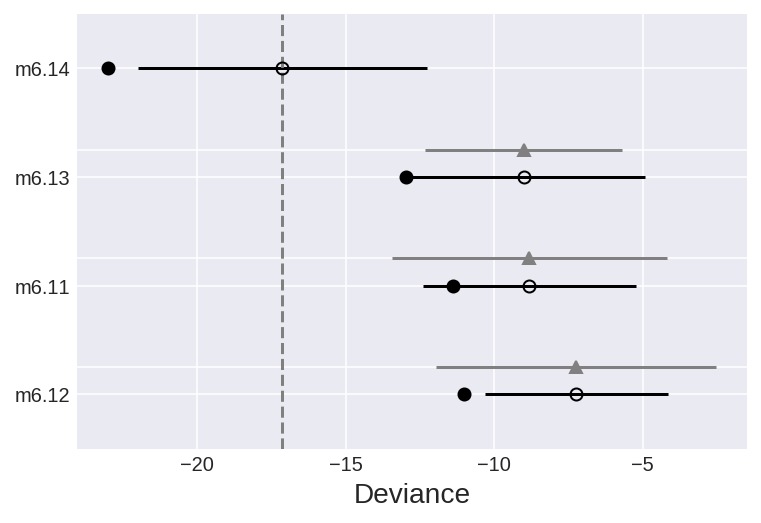

In [44]:
pm.compareplot(compare_df);

#### Code 6.26

In [45]:
diff = np.random.normal(loc=6.7, scale=7.26, size=100000)
sum(diff[diff<0]) / 100000

-0.6964024439646619

#### Code 6.27

Compare function already checks number of observations to be equal.

In [46]:
coeftab = pd.DataFrame({'m6_11': pm.summary(trace_m6_11)['mean'],
                        'm6_12': pm.summary(trace_m6_12)['mean'],
                        'm6_13': pm.summary(trace_m6_13)['mean'],
                        'm6_14': pm.summary(trace_m6_14)['mean']})
coeftab

,m6_11,m6_12,m6_13,m6_14
alpha,0.656843,0.363600,0.703038,-1.063030
beta,NaN,0.435967,-0.030810,NaN
beta__0,NaN,NaN,NaN,-0.095421
beta__1,NaN,NaN,NaN,2.757658
sigma,0.188117,0.194265,0.182760,0.139717


#### Code 6.28

In [47]:
traces = [trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14]   
models = [m6_11, m6_12, m6_13, m6_14]

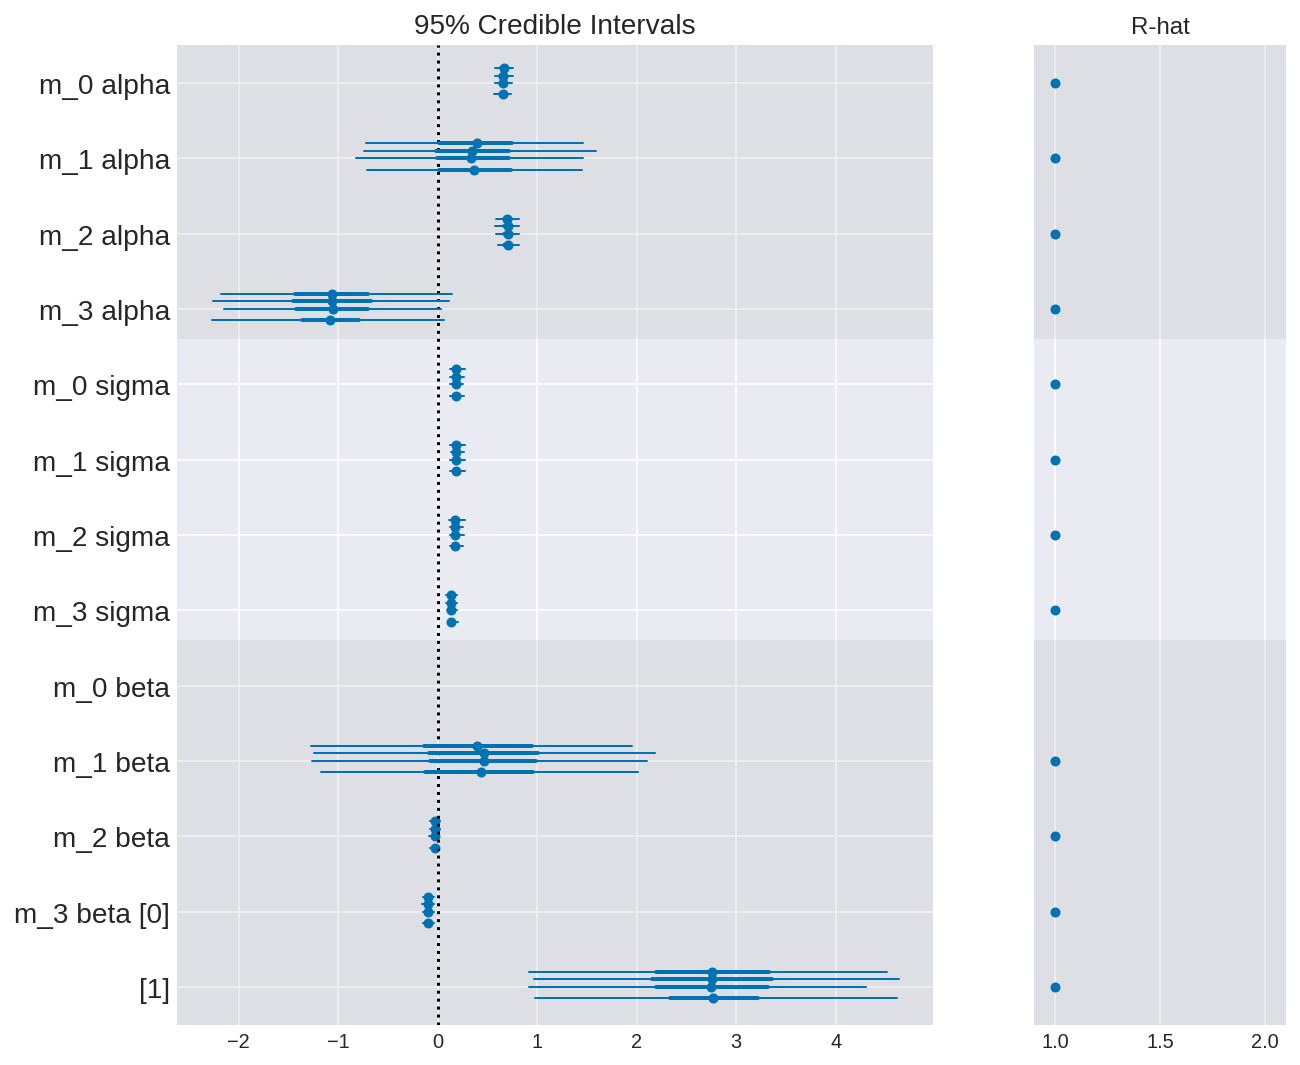

In [48]:
plt.figure(figsize=(10, 8))
pm.forestplot(traces, plot_kwargs={'fontsize':14});

#### Code 6.29

In [49]:
kcal_per_g = np.repeat(0, 30) # empty outcome
neocortex = np.linspace(0.5, 0.8, 30) # sequence of neocortex
mass = np.repeat(4.5, 30)     # average mass

In [50]:
mass_shared.set_value(np.log(mass))
neocortex_shared.set_value(neocortex)
post_pred = pm.sample_ppc(trace_m6_14, samples=10000, model=m6_14)

100%|██████████| 10000/10000 [00:04<00:00, 2044.40it/s]


#### Code 6.30

In [51]:
milk_ensemble = pm.sample_ppc_w(traces, 10000, 
                                models, weights=compare_df.weight.sort_index(ascending=True))

100%|██████████| 10000/10000 [00:04<00:00, 2464.00it/s]


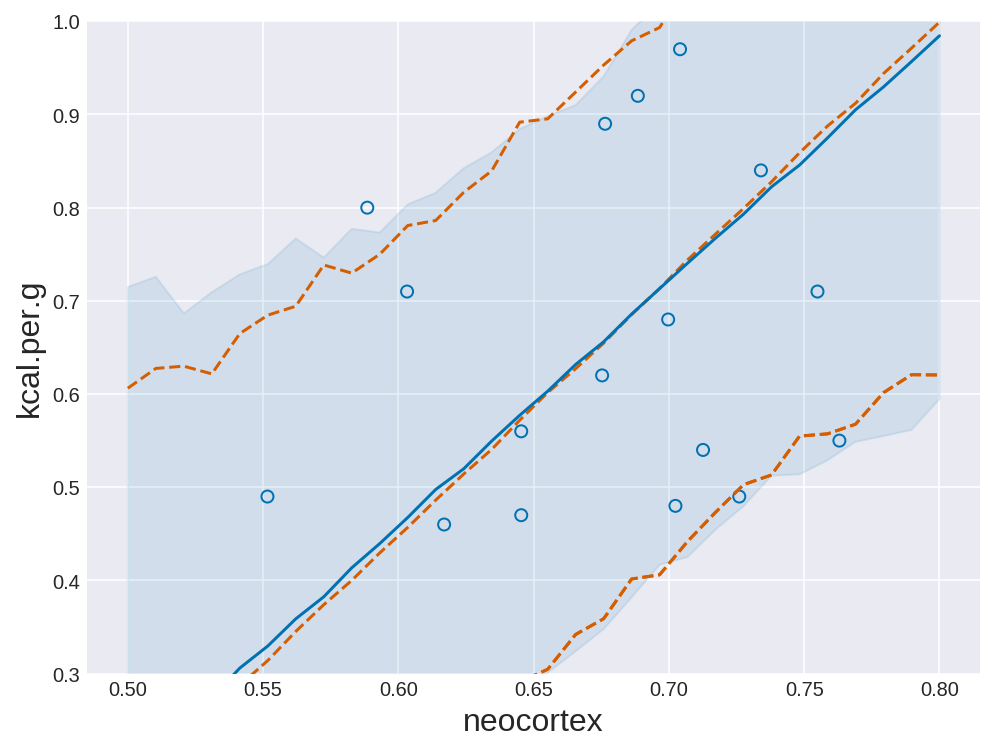

In [52]:
plt.figure(figsize=(8, 6))

plt.plot(neocortex, post_pred['kcal'].mean(0), ls='--', color='C2')
hpd_post_pred = pm.hpd(post_pred['kcal'])
plt.plot(neocortex,hpd_post_pred[:,0], ls='--', color='C2')
plt.plot(neocortex,hpd_post_pred[:,], ls='--', color='C2')

plt.plot(neocortex, milk_ensemble['kcal'].mean(0), color='C0')
hpd_av = pm.hpd(milk_ensemble['kcal'])
plt.fill_between(neocortex, hpd_av[:,0], hpd_av[:,1], alpha=0.1, color='C0')

plt.scatter(d['neocortex'], d['kcal.per.g'], facecolor='None', edgecolors='C0')

plt.ylim(0.3, 1)
plt.xlabel('neocortex', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16);

In [53]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.4
IPython 6.3.1
PyMC3 3.4.1
NumPy 1.14.2
Pandas 0.22.0
SciPy 1.0.1
Matplotlib 2.2.2



# Practice

## Easy

### 6E1
State the three motivating criteria that define information entropy. Try to express each in your own words.

> 1. The measure of uncertainty should be continuous. Similar to the reason neurons in neural networks are squashed via the sigmoid function into a continuous value between 0 and 1. Otherwise, small changes in probability could possibly result in large changes in uncertainty.

> 2. Uncertainty should increase as the number of possible events increases. This is a bit more obvious, but if there are 3 possibilities instead of 2, then 3 possibilities should generate more possible uncertainty.

> 3. Measure of uncertainty should be additive. If 3-4 different possibilities are independently measured for uncertainty, adding them should be possible to arrive at the overall uncertainty.

### 6E2
Suppose a coin is weighted such that, when it is tossed and lands on a table, it comes up heads 70% of the time. What is the entropy of this coin?

$$H(p) = - \sum_{i=1}^n p_i \log(p_i) $$
$$H(p) = - (0.7(\log(0.7)) + 0.3(\log(0.3))) = 0.61$$

### 6E3
Suppose a four-sided die is loaded such that, when tossed onto a table, it shows "1" 20%, "2" 25%, "3", 25%, and "4" 30% of the time. What is the entropy of the die?

```python
In [7]: p = (0.2, 0.25, 0.25, 0.3)

In [8]: -1 * sum(p * np.log(p))
Out[8]: 1.3762266043445461
```

### 6E4
Suppose another four-sided die is loaded such that it never shows "4". The other three sides are equal. What is the entropy of this die?

Undefined!

```python
In [9]: p = (0.33, 0.33, 0.33, 0)

In [10]: -1 * sum(p * np.log(p))
/anaconda3/bin/ipython:1: RuntimeWarning: divide by zero encountered in log
  #!/anaconda3/bin/python
/anaconda3/bin/ipython:1: RuntimeWarning: invalid value encountered in multiply
  #!/anaconda3/bin/python
Out[10]: nan
```

## Medium

### 6M1
Write down and compare the definitions of AIC, DIC, and WAIC. Which of these criteria is the most general? Which assumptions are required to trasnform a more general criterion into a less general one?

$$ \mbox{AIC} = D_{train} + 2p $$

$$ \mbox{DIC} = \bar{D} + (\bar{D} - \hat{D}) = \bar{D} + p_D $$

$$ \mbox{WAIC} = -2 (lppd - p_{WAIC}) $$
where
$$ \mbox{lppd} = \sum_{i=1}^N \log \Pr(y_i) $$
and
$$ p_{WAIC} = \sum_{i=1}^N V(y_i) $$

> DIC is like AIC except is "aware of informative priors" and uses a distribution of deviance. It also assumes a multivariate gaussian distribution.

> WAIC is the most general and is calculated _pointwise_ and does not assume a Gaussian posterior distribution. Assuming the posterior is Gaussian the simplest way to transform a general criterion into a less general one. 

### 6M2
Explain the difference betwen model selection and model averaging. What information is lost under model selection? What information is lost under model averaging?

> Model selection is using some objective measure (like information criteria) to understand why one model outperforms another. 

> Model averaging is synonymous with prediction averaging. Model averaging is not averaging over parameters which should almost never be done as the parameters represnt different things in different models.

> Very little information if any is lost under model averaging as model averaging will never make a predictor variable appear more influential than it already appears in any single model. 

### 6M3
When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values, if the models were fit to different numbers of observations? Perform some experiments if you are unsure. 

> This is important because models fit to different observations, models may be compared that have a different number of cases which will give it a better AIC/DIC/WAIC value because it was asked to predict less.

### 6M4
What happens to the effective number of parameters, as measured by DIC or WAIC, as a prior becomes more concentrated? Why? Perform some experiments if you are unsure.

> As a prior is concentrated, it restricts the amount of space other parameters can move around. This reduces the "flexibility" of the model and therefore how much overfitting can occur. 

> In WAIC, the effective parameters are calculated by $p_{WAIC} = \sum_{i=1}^N V(y_i)$ where $V(y_i)$ is the variance of the log-likelihood. A more concentrated prior will reduce the possible variance in the model.

### 6M5
Provide an informal explanation of why informative priors reduce overfitting.

> Informative priors produce a less flexible models which reduces overfitting by making it more difficult to learn from data in the training set. 

### 6M6
Provide an information explanation of why overly informative priors result in underfitting.

As touched on in **6M5**, an extremely informative prior will prevent the model from learning anything useful and therefore cause underfitting. 

## Hard
All data uses Howell dataset. Split into two equally sized dataframes.

Now let $h_i$ and $x_i$ be the height and centered age values, on row $i$. Fit the following models to the data in `d1`. 

$$ \mathcal{M}_1 : h_i \sim \mathcal{N}(\mu, \sigma)$$
$$ \mu_i = \alpha + \beta_1 x_i $$

$$ \mathcal{M}_2 : h_i \sim \mathcal{N}(\mu, \sigma)$$
$$ \mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 $$

$$ \mathcal{M}_3 : h_i \sim \mathcal{N}(\mu, \sigma)$$
$$ \mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + + \beta_3 x_i^3$$

$$ \mathcal{M}_4 : h_i \sim \mathcal{N}(\mu, \sigma)$$
$$ \mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \beta_4 x_i^4 $$

$$ \mathcal{M}_5 : h_i \sim \mathcal{N}(\mu, \sigma)$$
$$ \mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \beta_4 x_i^4 + \beta_5 x_i^5  $$

$$ \mathcal{M}_6 : h_i \sim \mathcal{N}(\mu, \sigma)$$
$$ \mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \beta_4 x_i^4 + \beta_5 x_i^5 + \beta_6 x_i^6 $$

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [24]:
df = pd.read_csv('data/Howell1.csv', sep=';')
df['height_s'] = (df.height - df.height.mean()) / df.height.std()
df['age_s'] = (df.age - df.age.mean()) / df.age.std()
df.head(2)

,height,weight,age,male,height_s,age_s
0,151.765,47.825606,63.0,1,0.489138,1.6222
1,139.700,36.485807,63.0,0,0.052039,1.6222


In [160]:
d1, d2 = train_test_split(df, test_size=0.5)
d1 = d1.sort_values('age_s', ascending=True)
d2 = d1.sort_values('age_s', ascending=True)

In [161]:
with pm.Model() as m1:
    pm.GLM.from_formula('height ~ age_s', d1)
    m1_trace = pm.sample()
    
with pm.Model() as m2:
    pm.GLM.from_formula('height ~ age_s + I(age_s**2)', d1)
    m2_trace = pm.sample()
    
with pm.Model() as m3:
    pm.GLM.from_formula('height ~ age_s + I(age_s**2) + I(age_s**3)', d1)
    m3_trace = pm.sample()

INFO (theano.gof.compilelock): Refreshing lock /Users/jvivian/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, age_s, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:10<00:00, 194.42draws/s]
The acceptance probability does not match the target. It is 0.9885301645223775, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, I(age_s ** 2), age_s, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:10<00:00, 187.53draws/s]
The acceptance probability does not match the target. It is 0.9003259505400958, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9935303148706244, but should be 

In [162]:
with pm.Model() as m4:
    pm.GLM.from_formula('height ~ age_s + I(age_s**2) + I(age_s**3) + I(age_s**4)', d1)
    m4_trace = pm.sample()
    
with pm.Model() as m5:
    pm.GLM.from_formula('height ~ age_s + I(age_s**2) + I(age_s**3) + I(age_s**4) + I(age_s**5)', d1)
    m5_trace = pm.sample()
    
with pm.Model() as m6:
    pm.GLM.from_formula('height ~ age_s + I(age_s**2) + I(age_s**3) + I(age_s**4) + I(age_s**5) + I(age_s**6)', d1)
    m6_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, I(age_s ** 4), I(age_s ** 3), I(age_s ** 2), age_s, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:14<00:00, 134.29draws/s]
The acceptance probability does not match the target. It is 0.9348121815864059, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9603517183787192, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/jvivian/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, I(age_s ** 5), I(age_s ** 4), I(age_s ** 3), I(age_s ** 2), age_s, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:38<00:00, 51.49draws/s] 
The 

### 6H1
Compare the models above using WAIC. Compare the model rankings as well as the WAIC weights

In [163]:
compare_df = pm.compare({m1 : m1_trace,
                         m2 : m2_trace,
                         m3 : m3_trace,
                         m4 : m4_trace,
                         m5 : m5_trace,
                         m6 : m6_trace}, method='pseudo-BMA')

compare_df

INFO (theano.gof.compilelock): Refreshing lock /Users/jvivian/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
3,1911.76,5.69,0,0.51,26.34,0,1
4,1912.97,6.25,1.21,0.28,26.11,0.5,1
5,1913.46,7.02,1.7,0.22,25.77,2.15,1
2,1937.37,6.19,25.61,0,25.57,11.22,1
1,2154.13,7.37,242.37,0,27.22,31.46,1
0,2380.74,3.65,468.98,0,23.63,32.46,0


In [219]:
pm.compare?

### 6H2
For each model, produce a plot with model averaged mean and 97% confidence interval of the mean, superimposed on the raw data. How do predictions differ across models? 

#### M1

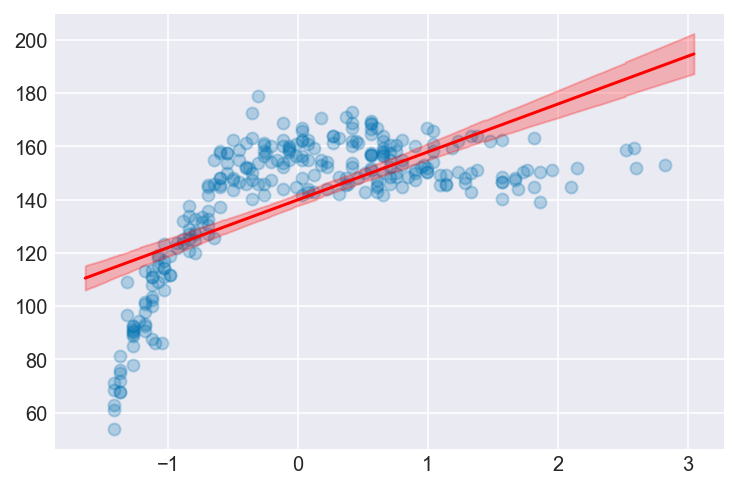

In [164]:
plt.scatter(d1.age_s, d1.height, alpha=0.25)

x = np.linspace(*plt.xlim(), len(m1_trace['Intercept']))
y = m1_trace['Intercept'].mean() + m1_trace['age_s'].mean() * x
plt.plot(x, y, c='r');

mu_pred = m1_trace['Intercept'] + m1_trace['age_s'] * x[:,None]
mu_hpd = pm.hpd(mu_pred.T)
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='red', alpha=0.25)

#### M2

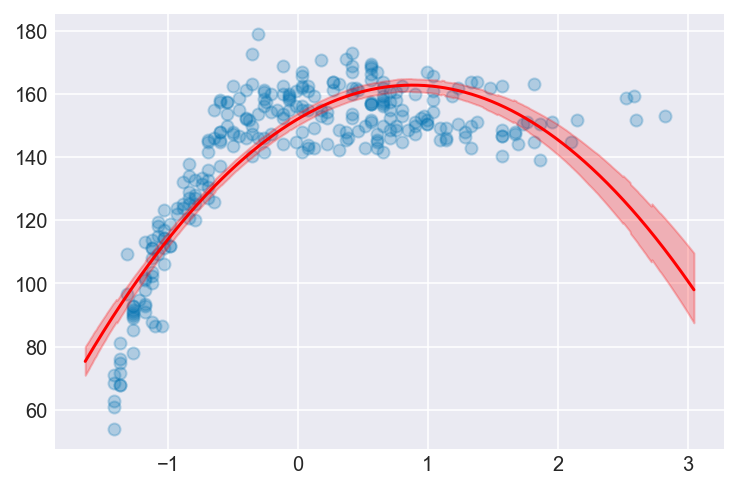

In [165]:
plt.scatter(d1.age_s, d1.height, alpha=0.25)

x = np.linspace(*plt.xlim(), len(m1_trace['Intercept']))
y = m2_trace['Intercept'].mean() + m2_trace['age_s'].mean() * x + \
    m2_trace['I(age_s ** 2)'].mean() * x**2
plt.plot(x, y, c='r');

mu_pred = m2_trace['Intercept'] + m2_trace['age_s'] * x[:,None] + \
    m2_trace['I(age_s ** 2)'] * x[:,None]**2
mu_hpd = pm.hpd(mu_pred.T)
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='red', alpha=0.25);

#### M3

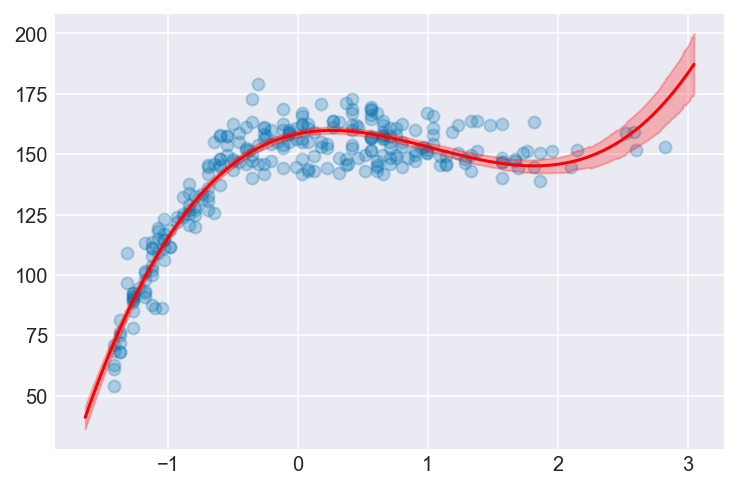

In [166]:
plt.scatter(d1.age_s, d1.height, alpha=0.25)

x = np.linspace(*plt.xlim(), len(m1_trace['Intercept']))
y = m3_trace['Intercept'].mean() + m3_trace['age_s'].mean() * x + \
    m3_trace['I(age_s ** 2)'].mean() * x**2 + m3_trace['I(age_s ** 3)'].mean() * x**3
plt.plot(x, y, c='r');

mu_pred = m3_trace['Intercept'] + m3_trace['age_s'] * x[:,None] + \
    m3_trace['I(age_s ** 2)'] * x[:,None]**2 + m3_trace['I(age_s ** 3)'] * x[:,None]**3
mu_hpd = pm.hpd(mu_pred.T)
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='red', alpha=0.25);

#### M4

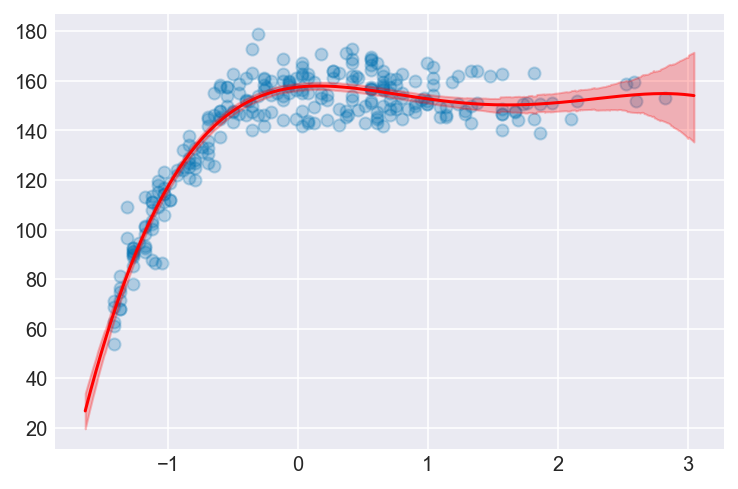

In [186]:
plt.scatter(d1.age_s, d1.height, alpha=0.25)

x = np.linspace(*plt.xlim(), len(m1_trace['Intercept']))
y = m4_trace['Intercept'].mean() + m4_trace['age_s'].mean() * x + \
    m4_trace['I(age_s ** 2)'].mean() * x**2 + m4_trace['I(age_s ** 3)'].mean() * x**3 + \
    m4_trace['I(age_s ** 4)'].mean() * x**4
plt.plot(x, y, c='r');
plt.ylim

mu_pred = m4_trace['Intercept'] + m4_trace['age_s'] * x[:,None] + \
    m4_trace['I(age_s ** 2)'] * x[:,None]**2 + m4_trace['I(age_s ** 3)'] * x[:,None]**3 + \
    m4_trace['I(age_s ** 4)'] * x[:,None]**4
mu_hpd = pm.hpd(mu_pred.T)
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='red', alpha=0.25);

#### M5

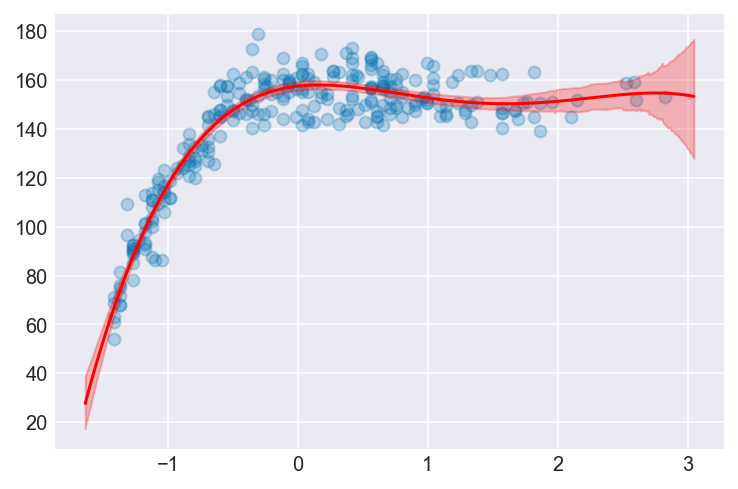

In [168]:
plt.scatter(d1.age_s, d1.height, alpha=0.25)

x = np.linspace(*plt.xlim(), len(m1_trace['Intercept']))
y = m5_trace['Intercept'].mean() + m5_trace['age_s'].mean() * x + \
    m5_trace['I(age_s ** 2)'].mean() * x**2 + m5_trace['I(age_s ** 3)'].mean() * x**3 + \
    m5_trace['I(age_s ** 4)'].mean() * x**4 + m5_trace['I(age_s ** 5)'].mean() * x**5
plt.plot(x, y, c='r');

mu_pred = m5_trace['Intercept'] + m5_trace['age_s'] * x[:,None] + \
    m5_trace['I(age_s ** 2)'] * x[:,None]**2 + m5_trace['I(age_s ** 3)'] * x[:,None]**3 + \
    m5_trace['I(age_s ** 4)'] * x[:,None]**4 + m5_trace['I(age_s ** 5)'] * x[:,None]**5
mu_hpd = pm.hpd(mu_pred.T)
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='red', alpha=0.25);

#### M6

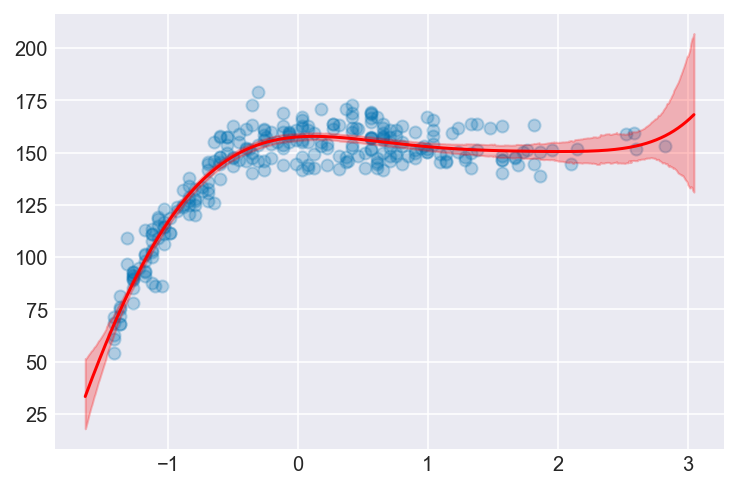

In [169]:
plt.scatter(d1.age_s, d1.height, alpha=0.25)

x = np.linspace(*plt.xlim(), len(m1_trace['Intercept']))
y = m6_trace['Intercept'].mean() + m6_trace['age_s'].mean() * x + \
    m6_trace['I(age_s ** 2)'].mean() * x**2 + m6_trace['I(age_s ** 3)'].mean() * x**3 + \
    m6_trace['I(age_s ** 4)'].mean() * x**4 + m6_trace['I(age_s ** 5)'].mean() * x**5 + \
    m6_trace['I(age_s ** 6)'].mean() * x**6
plt.plot(x, y, c='r');

mu_pred = m6_trace['Intercept'] + m6_trace['age_s'] * x[:,None] + \
    m6_trace['I(age_s ** 2)'] * x[:,None]**2 + m6_trace['I(age_s ** 3)'] * x[:,None]**3 + \
    m6_trace['I(age_s ** 4)'] * x[:,None]**4 + m6_trace['I(age_s ** 5)'] * x[:,None]**5 + \
    m6_trace['I(age_s ** 6)'] * x[:,None]**6
mu_hpd = pm.hpd(mu_pred.T)
plt.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='red', alpha=0.25);

### 6H3
Now also plot the model averaged predictions, across all models. In what ways do the averaged predictions differ from the predictions of the model with the lowest WAIC value?

In [170]:
traces = [m1_trace, m2_trace, m3_trace, m4_trace, m5_trace, m6_trace]
models = [m1, m2, m3, m4, m5, m6]

In [172]:
ensemble = pm.sample_ppc_w(traces, 
                           10000, 
                           models,
                           weights=compare_df.weight.sort_index(ascending=True))

100%|██████████| 10000/10000 [00:11<00:00, 905.50it/s]


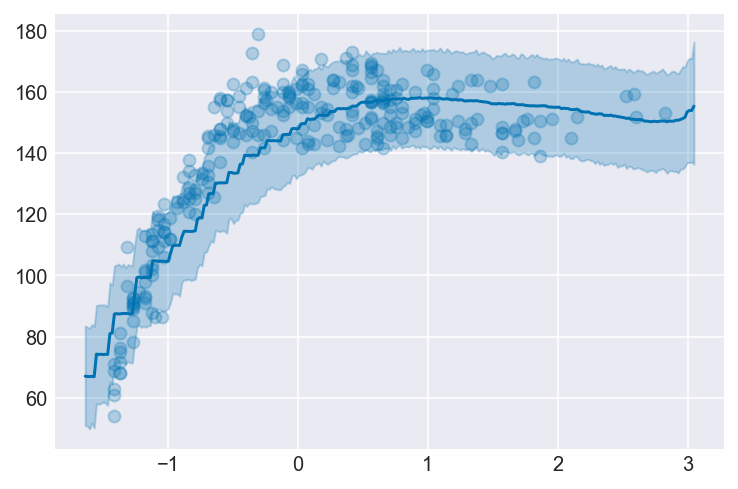

In [177]:
plt.scatter(d1.age_s, d1.height, alpha=0.25)
x = np.linspace(*plt.xlim(), len(d1.age_s))
plt.plot(x, ensemble['y'].mean(0), color='C0')
hpd = pm.hpd(ensemble['y'])
plt.fill_between(x, hpd[:,0], hpd[:,1], alpha=0.25, color='C0')

### 6H4 
Compute the test-sample deviance for each model. This means calculating deviance, but using the data in `d2` now. You can compute the log-likelihood of the height data with:

```R
sum( dnorm (d2$height, mu, sigma, log=True))
```

Where `mu` is the vector of predicted means (based upon age values and MAP parameters) and `sigma` is the MAP standard deviation. 

In [233]:
x = d2.age_s#np.linspace(min(d2.age_s), max(d2.age_s), len(d2.height))

m1_pred = m1_trace['Intercept'] + m1_trace['age_s'] * x[:,None]

m2_pred = m2_trace['Intercept'] + m2_trace['age_s'] * x[:,None] + \
    m2_trace['I(age_s ** 2)'] * x[:,None]**2
    
m3_pred = m3_trace['Intercept'] + m3_trace['age_s'] * x[:,None] + \
    m3_trace['I(age_s ** 2)'] * x[:,None]**2 + m3_trace['I(age_s ** 3)'] * x[:,None]**3

m4_pred = m4_trace['Intercept'] + m4_trace['age_s'] * x[:,None] + \
    m4_trace['I(age_s ** 2)'] * x[:,None]**2 + m4_trace['I(age_s ** 3)'] * x[:,None]**3 + \
    m4_trace['I(age_s ** 4)'] * x[:,None]**4

m5_pred = m5_trace['Intercept'] + m5_trace['age_s'] * x[:,None] + \
    m5_trace['I(age_s ** 2)'] * x[:,None]**2 + m5_trace['I(age_s ** 3)'] * x[:,None]**3 + \
    m5_trace['I(age_s ** 4)'] * x[:,None]**4 + m5_trace['I(age_s ** 5)'] * x[:,None]**5

m6_pred = m6_trace['Intercept'] + m6_trace['age_s'] * x[:,None] + \
    m6_trace['I(age_s ** 2)'] * x[:,None]**2 + m6_trace['I(age_s ** 3)'] * x[:,None]**3 + \
    m6_trace['I(age_s ** 4)'] * x[:,None]**4 + m6_trace['I(age_s ** 5)'] * x[:,None]**5 + \
    m6_trace['I(age_s ** 6)'] * x[:,None]**6

Deviance is computed as

$$ D(q) = -2 \sum_i \log(q_i) $$

In [252]:
st.norm?

In [253]:
print(-2 * sum(st.norm.logpdf(d2.height, loc=m1_pred.mean(1), scale=m1_trace['sd'].mean())))
print(-2 * sum(st.norm.logpdf(d2.height, loc=m2_pred.mean(1), scale=m2_trace['sd'].mean())))
print(-2 * sum(st.norm.logpdf(d2.height, loc=m3_pred.mean(1), scale=m3_trace['sd'].mean())))
print(-2 * sum(st.norm.logpdf(d2.height, loc=m4_pred.mean(1), scale=m4_trace['sd'].mean())))
print(-2 * sum(st.norm.logpdf(d2.height, loc=m5_pred.mean(1), scale=m5_trace['sd'].mean())))
print(-2 * sum(st.norm.logpdf(d2.height, loc=m6_pred.mean(1), scale=m6_trace['sd'].mean())))

2374.021854272475
2142.387271138073
1925.6008675340665
1899.4908483548595
1899.5400035808948
1898.4518045167656


The smallest value is model 6 with a deviance of 1898 followed closely by models 5 and 4. 

### 6H5
Compare the deviances from **6H4** to the WAIC values. It might be easier to compare if you subtract the smallest value in each list from the others. For example, subtract the minimum WAIC from all of the WAIC values so that the best WAIC is normalized to zero. Which model makes the best out-of-sample predictions in this case? Does WAIC do a good job of estimating the test deviance?

In [256]:
compare_df = compare_df.sort_index()
compare_df.WAIC - min(compare_df.WAIC)

0    468.98
1    242.37
2     25.61
3         0
4      1.21
5       1.7
Name: WAIC, dtype: object

In [255]:
min_dev = 1898.4518045167656
print(2374.021854272475 - min_dev)
print(2142.387271138073 - min_dev)
print(1925.6008675340665 - min_dev)
print(1899.4908483548595 - min_dev)
print(1899.5400035808948 - min_dev)
print(1898.4518045167656 - min_dev)

475.57004975570953
243.93546662130757
27.149063017300932
1.039043838093903
1.088199064129185
0.0


Model 6 narrowly makes the best out-of-sample predictions in this case. WAIC appears to do a fantastic job of estimating test deviance. 

### 6H6
Consider the following model:
$$ h_i \sim \mathcal{N}(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \beta_4 x_i^4 + \beta_5 x_i^5 + \beta_6 x_i^6 $$
$$ \beta_1 \sim \mathcal{N}(0, 5) $$
$$ \beta_2 \sim \mathcal{N}(0, 5) $$
$$ \beta_3 \sim \mathcal{N}(0, 5) $$
$$ \beta_4 \sim \mathcal{N}(0, 5) $$
$$ \beta_5 \sim \mathcal{N}(0, 5) $$
$$ \beta_6 \sim \mathcal{N}(0, 5) $$

and assume flat (or nearly flat) priors on $\alpha$ and $\sigma$. This model contains more strongly regularizing priors on the coefficients. 

First, fit this model to the data in `d1`. Report the MAP estimates and plot the implied predictions. Then compute the out-of-sample deviance using the data in `d2`, using MAP estimates from the model fit to `d1` only. How does this model, using regularizing priors, compare to the best WAIC model from earlier? How do you interpret this result?

In [270]:
with pm.Model() as h6:
    alpha = pm.Normal('alpha', 0, 100)
    sigma = pm.InverseGamma('sigma', 1)
    beta = pm.Normal('beta', 0, 5, shape=6)
    
    mu = alpha + beta[0] * d1.age_s + beta[1] * d1.age_s**2 + \
        beta[2] * d1.age_s**3 + beta[3] * d1.age_s**4 + beta[3] * d1.age_s**4 + \
        beta[4] * d1.age_s**5 + beta[5] * d1.age_s**6
        
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1.height)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/jvivian/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, sigma, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:59<00:00, 12.41draws/s]
The acceptance probability does not match the target. It is 0.9349036933390528, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.919258614699876, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [273]:
pm.waic(trace, h6)

/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=1917.2000548863468, WAIC_se=26.831806333785455, p_WAIC=6.759781643411889, var_warn=1)

Now let's use weakly regularizing priors

In [287]:
with pm.Model() as weak_h6:
    alpha = pm.Normal('alpha', 0, 100)
    sigma = pm.InverseGamma('sigma', 1)
    beta = pm.Normal('beta', 0, 100, shape=6)
    
    mu = alpha + beta[0] * d1.age_s + beta[1] * d1.age_s**2 + \
        beta[2] * d1.age_s**3 + beta[3] * d1.age_s**4 + beta[3] * d1.age_s**4 + \
        beta[4] * d1.age_s**5 + beta[5] * d1.age_s**6
        
    h = pm.Normal('h', mu=mu, sd=sigma, observed=d1.height)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/jvivian/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, sigma, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:26<00:00, 23.05draws/s]
The acceptance probability does not match the target. It is 0.9555964936038089, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856539680791813, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [288]:
pm.waic(trace, weak_h6)

/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=1914.3611756557796, WAIC_se=25.85213436814661, p_WAIC=7.44270792269026, var_warn=1)

Using strongly regularized parameters prevented it from learning as much about the data, resulting in a higher WAIC score. 